**Imports**

In [69]:
# Enable inline plotting for Google Colab
%matplotlib inline

# Import necessary libraries
import matplotlib.pyplot as plt  # For general plotting
from matplotlib.ticker import MaxNLocator
from math import ceil, floor

import numpy as np

from scipy.stats import multivariate_normal as mvn
from skimage.io import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

# Set options for numpy to display numbers without scientific notation
np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Set global plotting configurations for better visualization
plt.rc('axes', titlesize=20)  # Font size of the Title
plt.rc('font', size=24)  # Font size for text
plt.rc('axes', labelsize=18)  # Font size for the x and y labels
plt.rc('xtick', labelsize=16)  # Font size of the x-axis tick labels
plt.rc('ytick', labelsize=16)  # Font size of the y-axis tick labels
plt.rc('legend', fontsize=14)  # Font size of the legend
plt.rc('figure', titlesize=24)  # Font size of the figure title

**Utility Functions**

In [70]:
def plot_binary_classification_results(ax, predictions, labels):
    # Get indices of the four decision scenarios:
    # True Negatives
    tn = np.argwhere((predictions == -1) & (labels == -1))
    # False Positives
    fp = np.argwhere((predictions == 1) & (labels == -1))
    # False Negatives
    fn = np.argwhere((predictions == -1) & (labels == 1))
    # True Positives
    tp = np.argwhere((predictions == 1) & (labels == 1))

    # Plot points based on classification results
    ax.plot(X_test[tn, 0], X_test[tn, 1], 'og', label="Correct Class -1")  # True Negatives
    ax.plot(X_test[fp, 0], X_test[fp, 1], 'or', label="Incorrect Class -1")  # False Positives
    ax.plot(X_test[fn, 0], X_test[fn, 1], '+r', label="Incorrect Class 1")  # False Negatives
    ax.plot(X_test[tp, 0], X_test[tp, 1], '+g', label="Correct Class 1")  # True Positives

**Generate Multiring Dataset**

In [71]:
def generate_multiring_dataset(num_samples, n, pdf_params):
    # Output samples and labels
    X = np.zeros((num_samples, n))
    # Note that the labels are either -1 or +1 for binary classification
    labels = np.ones(num_samples)

    # Decide randomly which samples will come from each class
    indices = np.random.rand(num_samples) < pdf_params['prior']
    # Reassign random samples to the negative class values (-1)
    labels[indices] = -1
    num_neg = sum(indices)

    # Create mixture distribution
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=num_samples)
    uniform_component = np.array([np.cos(theta), np.sin(theta)]).T

    # Positive class samples
    X[~indices] = (
        pdf_params['r+'] * uniform_component[~indices] +
        mvn.rvs(pdf_params['mu'], pdf_params['Sigma'], num_samples - num_neg)
    )
    # Negative class samples
    X[indices] = (
        pdf_params['r-'] * uniform_component[indices] +
        mvn.rvs(pdf_params['mu'], pdf_params['Sigma'], num_neg)
    )

    return X, labels

**Function to Plot Dataset**

In [72]:
def plot_dataset(ax, X, y, title):
    ax.set_title(title)
    ax.plot(X[y == -1, 0], X[y == -1, 1], 'go', label="Class -1")
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'r+', label="Class 1")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.legend()

**Generate and Visualize Training and Test Sets**

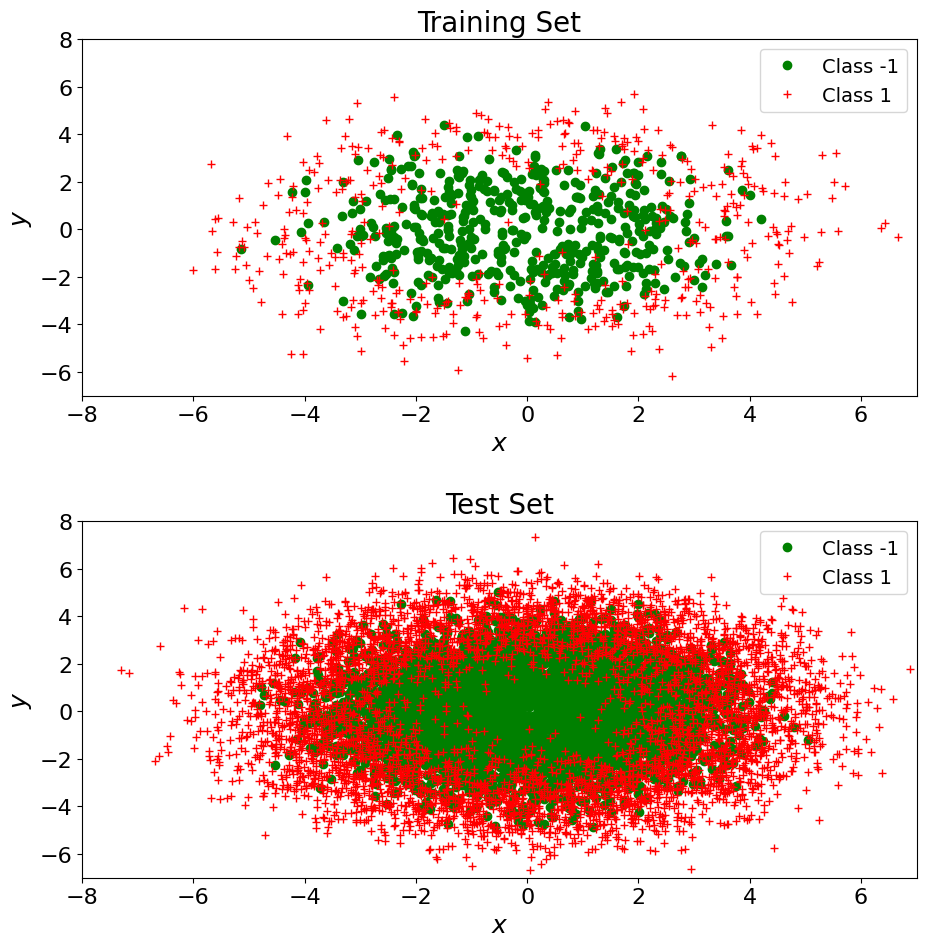

In [73]:
# Two-dimensional data
n = 2
mix_pdf = {
    'r+': 4,  # Radius for positive class
    'r-': 2,  # Radius for negative class
    'prior': 0.5,  # Prior probability for class -1
    'mu': np.zeros(n),  # Mean vector for Gaussian noise
    'Sigma': np.identity(n)  # Covariance matrix for Gaussian noise
}

# Number of training and test set samples
N_train = 1000
N_test = 10000

# Generate training and test sets
X_train, y_train = generate_multiring_dataset(N_train, n, mix_pdf)
X_test, y_test = generate_multiring_dataset(N_test, n, mix_pdf)

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

plot_dataset(ax[0], X_train, y_train, "Training Set")
plot_dataset(ax[1], X_test, y_test, "Test Set")

# Using test set samples to limit axes
x1_lim = (np.floor(np.min(X_test[:, 0])), np.ceil(np.max(X_test[:, 0])))
x2_lim = (np.floor(np.min(X_test[:, 1])), np.ceil(np.max(X_test[:, 1])))
plt.setp(ax, xlim=x1_lim, ylim=x2_lim)
plt.tight_layout()
plt.show()

**10-Fold Cross-Validation for SVM Hyperparameter Tuning**

In [74]:
# Set the number of folds for cross-validation
K = 10

# Define parameter ranges for GridSearchCV
regularization_strengths = np.logspace(-3, 3, 7)  # Range for the regularization strength (C)
kernel_widths = np.logspace(-3, 3, 7)  # Range for the kernel width (gamma)
param_grid = {'C': regularization_strengths, 'gamma': kernel_widths}

# Initialize an SVM classifier with Gaussian (RBF) kernel
svm_classifier = SVC(kernel='rbf')

# Define K-fold cross-validator
cross_validator = KFold(n_splits=K, shuffle=True)

# Perform grid search with cross-validation
classifier = GridSearchCV(svm_classifier, param_grid=param_grid, cv=cross_validator)
classifier.fit(X_train, y_train)

# Extract the best parameters
best_regularization_strength = classifier.best_params_['C']
best_kernel_width = classifier.best_params_['gamma']

# Print the best hyperparameters and their performance
print(f"Best Regularization Strength: {best_regularization_strength:.3f}")
print(f"Best Kernel Width: {best_kernel_width:.3f}")
print(f"SVM CV Pr(error): {1 - classifier.best_score_:.3f}")

Best Regularization Strength: 100.000
Best Kernel Width: 0.001
SVM CV Pr(error): 0.171


**Visualization of Cross-Validation Results**

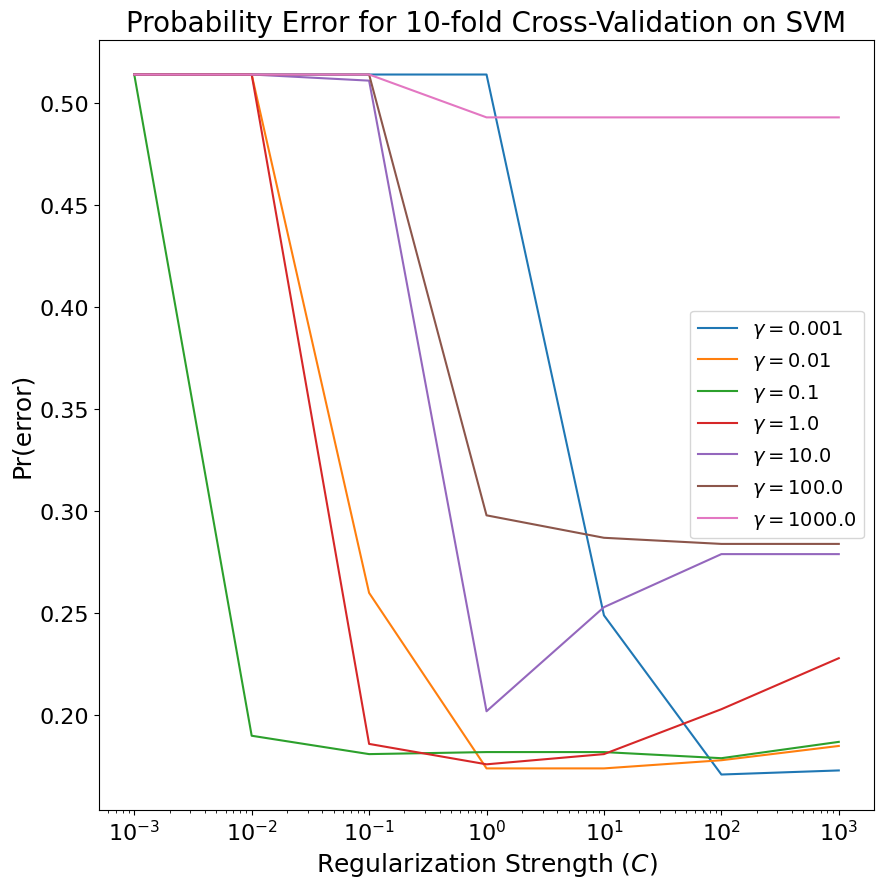

In [75]:
# Extract grid search results
regularization_data = classifier.cv_results_['param_C']
gamma_data = classifier.cv_results_['param_gamma']
cv_prob_error = 1 - classifier.cv_results_['mean_test_score']

# Plot probability of error as a function of C and gamma
plt.figure(figsize=(10, 10))

# Loop through each kernel width to plot
for g in kernel_widths:
    # Find indices corresponding to the current gamma value
    gamma_indices = np.where(gamma_data == g)[0]

    # Sort the indices based on regularization strength for plotting
    sort_idx = np.argsort(regularization_data[gamma_indices])
    sorted_regularization = regularization_data[gamma_indices][sort_idx]
    sorted_prob_error = cv_prob_error[gamma_indices][sort_idx]

    # Plot Pr(error) for the current gamma value
    plt.plot(sorted_regularization, sorted_prob_error, label=fr"$\gamma = {g}$")

# Customize the plot
plt.title("Probability Error for 10-fold Cross-Validation on SVM")
plt.xscale('log')  # Logarithmic scale for regularization strength
plt.xlabel(r"Regularization Strength ($C$)")
plt.ylabel("Pr(error)")
plt.legend()
plt.show()

**Train SVM Using Best Parameters and Evaluate on Test Dataset**

In [76]:
# Train SVM using the best parameters on the entire training dataset
svm_classifier = SVC(C=best_regularization_strength, kernel='rbf', gamma=best_kernel_width)
svm_classifier.fit(X_train, y_train)
test_predictions = svm_classifier.predict(X_test)

# Calculate the probability of error on the test dataset
incorrect_indices = np.argwhere(y_test != test_predictions)
test_error_probability = len(incorrect_indices) / N_test
print("Test Set Probability of Error for SVM: %.4f\n" % test_error_probability)

Test Set Probability of Error for SVM: 0.1729



**Plot Binary Classification Results and Decision Boundaries**

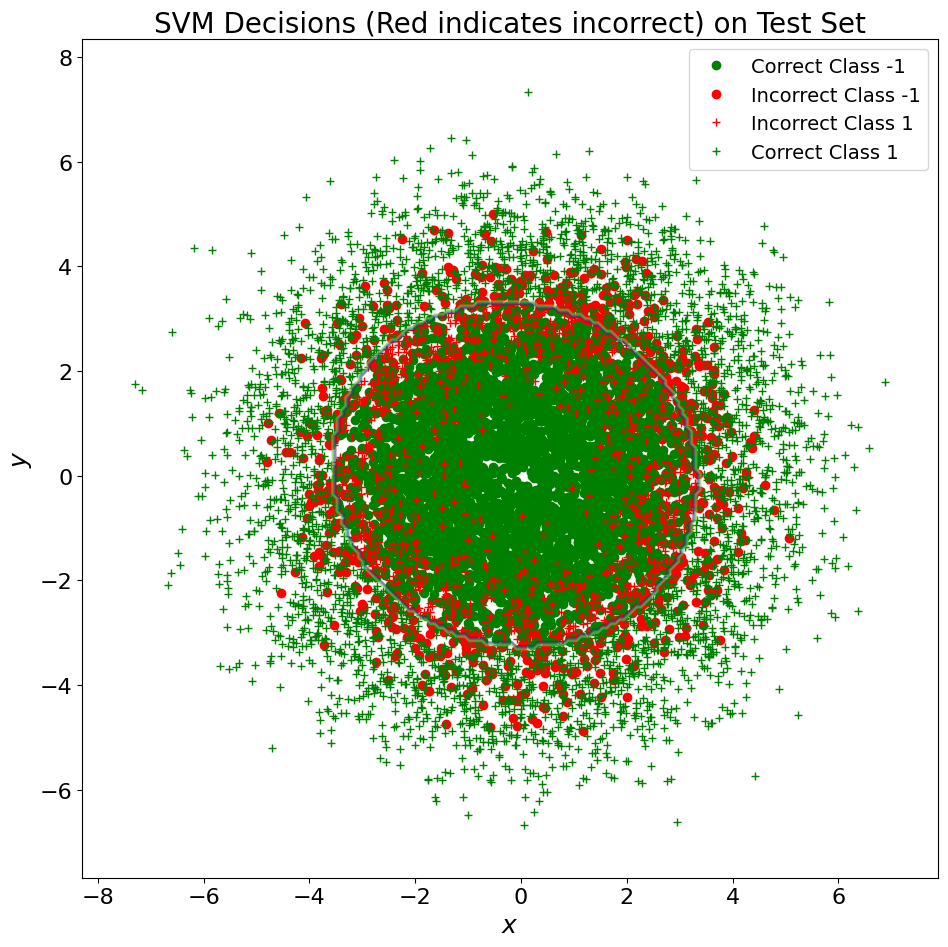

In [77]:
# Plot the binary classification results and SVM decision boundaries on the test set
fig, ax = plt.subplots(figsize=(10, 10))
plot_binary_classification_results(ax, test_predictions, y_test)

# Define the region of interest based on data limits
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
x_span = np.linspace(x_min, x_max, num=200)
y_span = np.linspace(y_min, y_max, num=200)
xx, yy = np.meshgrid(x_span, y_span)

# Prepare grid points for decision boundary predictions
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Z matrix represents the SVM classifier predictions for the grid points
decision_boundary = svm_classifier.predict(grid_points).reshape(xx.shape)
ax.contour(xx, yy, decision_boundary, cmap=plt.cm.viridis, alpha=0.25)

# Add labels, title, and legend
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("SVM Decisions (Red indicates incorrect) on Test Set")
ax.legend()

# Adjust layout and display plot
plt.tight_layout()
plt.show()

**Display Confusion Matrix Using scikit-learn**

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

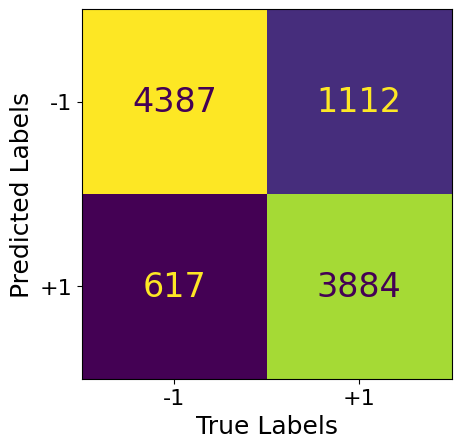

In [78]:
# Simply using scikit-learn's confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(test_predictions, y_test)

# Display the confusion matrix
conf_display = ConfusionMatrixDisplay.from_predictions(
    test_predictions, y_test, display_labels=['-1', '+1'], colorbar=False
)

# Add axis labels
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

**Train Function for Binary Classification**

In [79]:
def train_model(model, input_data, target_labels, optimizer, criterion=nn.BCEWithLogitsLoss(), num_epochs=100):
    # Set the model in training mode
    model.train()

    for epoch in range(num_epochs):
        # Forward pass: compute predicted probabilities
        predicted_logits = model(input_data)
        # Calculate the loss between predictions and target labels
        loss = criterion(predicted_logits, target_labels.unsqueeze(1))

        # Clear gradients before backward pass
        optimizer.zero_grad()
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()

    return model, loss

**Predict Function for Binary Classification**

In [80]:
def predict_with_model(model, input_data):
    # Set the model in evaluation mode
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass: get predicted logits
        predicted_logits = model(input_data)
        # Apply sigmoid to logits for obtaining output probabilities
        predicted_probs = torch.sigmoid(predicted_logits).detach().numpy()
        # Reshape to remove unnecessary dimensions
        return predicted_probs.reshape(-1)

**Train Perceptron Model for Binary Classification**

In [81]:
def train_perceptron_model(model, input_data, target_labels, optimizer, num_epochs=100):
    # Set the model in training mode
    model.train()

    # Define the loss function (handles sigmoid internally)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Forward pass: compute logits
        predicted_logits = model(input_data)
        # Compute the loss
        loss = criterion(predicted_logits, target_labels.unsqueeze(1))  # Unsqueeze to match logits shape

        # Clear the gradients before backward pass
        optimizer.zero_grad()
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()

    return model, loss

**TwoLayerMLP Class Implementation**

In [82]:
import torch.nn as nn

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TwoLayerMLP, self).__init__()
        # Define the hidden layer
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, 1)  # Binary classification: single output node

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))  # ReLU activation for the hidden layer
        x = self.output_layer(x)  # Output logits (no activation)
        return x

**K-Fold Cross-Validation for Perceptron Model**

In [83]:
def k_fold_cross_validation(K, perceptron_options, data, labels):
    # Step 1: Partition the dataset into K approximately equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True)

    # Allocate space for cross-validation errors
    error_valid_perceptrons = np.zeros((len(perceptron_options), K))

    # Step 2: Iterate over all perceptron options based on the number of perceptrons
    for m, perceptrons in enumerate(perceptron_options):
        # K-fold cross-validation
        for k, (train_indices, valid_indices) in enumerate(kf.split(data)):
            # Extract the training and validation sets from the K-fold split
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.FloatTensor(labels[train_indices])
            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = torch.FloatTensor(labels[valid_indices])

            # Create the perceptron model
            model = TwoLayerMLP(X_train_k.shape[1], perceptrons)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

            # Train the model
            model, _ = train_perceptron_model(model, X_train_k, y_train_k, optimizer)

            # Evaluate the model on the validation fold
            prediction_probs = predict_with_model(model, X_valid_k)
            predictions = np.round(prediction_probs)

            # Retain the probability of error estimates
            error_valid_perceptrons[m, k] = np.sum(predictions != y_valid_k.numpy()) / len(y_valid_k)

    # Step 3: Compute the average probability of error (across K folds) for each model
    average_error_perceptrons = np.mean(error_valid_perceptrons, axis=1)

    # Find the optimal choice of perceptrons
    optimal_perceptrons = perceptron_options[np.argmin(average_error_perceptrons)]

    print(f"Best Number of Perceptrons: {optimal_perceptrons}")
    print(f"Average Cross-Validation Probability of Error: {np.min(average_error_perceptrons):.3f}")

    # Plot the cross-validation results
    plt.figure(figsize=(10, 10))
    plt.plot(perceptron_options, average_error_perceptrons)
    plt.title("Number of Perceptrons vs Cross-Validation Probability of Error")
    plt.xlabel("Number of Perceptrons")
    plt.ylabel("MLP Cross-Validation Probability of Error")
    plt.show()

    return optimal_perceptrons

**Hyperparameter Search for Number of Perceptrons**

Best Number of Perceptrons: 64
Average Cross-Validation Probability of Error: 0.178


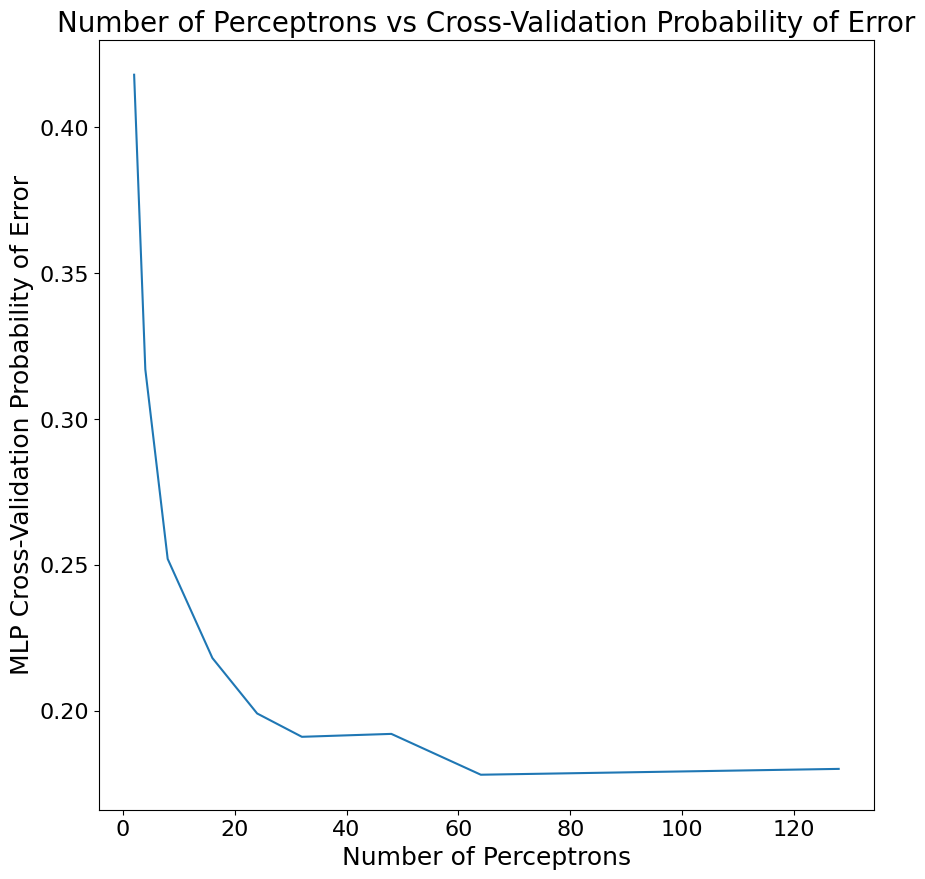

Optimal Number of Perceptrons: 64


In [84]:
# List of perceptron counts to evaluate
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128]

# Convert -1/+1 labels into binary format (0/1), suitable for the MLP loss function
lb = LabelBinarizer()
y_train_binary = lb.fit_transform(y_train)[:, 0]

# Perform K-Fold Cross-Validation to find the best number of perceptrons
P_best = k_fold_cross_validation(K, P_list, X_train, y_train_binary)

# Output the best number of perceptrons
print(f"Optimal Number of Perceptrons: {P_best}")

**MLP Training with Model Restarts**

In [85]:
# Function to Train with Model Restarts
def train_with_restarts(model_class, input_size, hidden_size, X_train, y_train, num_restarts=10, num_epochs=100):
    best_loss = float('inf')
    best_model = None
    criterion = torch.nn.BCEWithLogitsLoss()

    for restart in range(num_restarts):
        # Initialize a new model instance with random weights
        model = model_class(input_size, hidden_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        model.train()

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            logits = model(X_train)  # Compute logits
            loss = criterion(logits, y_train.unsqueeze(1))  # Compute loss
            loss.backward()
            optimizer.step()

        # Keep track of the best-performing model
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model

    return best_model

**Model Evaluation and Visualization**

In [86]:
def evaluate_and_visualize(model, X_test, y_test, lb):
    model.eval()
    with torch.no_grad():
        logits = model(X_test)  # Compute logits
        probabilities = torch.sigmoid(logits).numpy().flatten()
        predictions = (probabilities > 0.5).astype(int)
        decoded_predictions = lb.inverse_transform(predictions.reshape(-1, 1))
        decoded_y_test = lb.inverse_transform(y_test.reshape(-1, 1))

    # Calculate the test error probability
    test_error_probability = np.mean(decoded_predictions != decoded_y_test)
    print(f"Test Set Probability of Error: {test_error_probability:.4f}")

    # Plot binary classification results
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("MLP Decisions (Red indicates incorrect) on Test Set")

    # Identify correct and incorrect predictions
    correct_class_minus_1 = (decoded_y_test == -1) & (decoded_predictions == -1)
    incorrect_class_minus_1 = (decoded_y_test == -1) & (decoded_predictions == 1)
    correct_class_plus_1 = (decoded_y_test == 1) & (decoded_predictions == 1)
    incorrect_class_plus_1 = (decoded_y_test == 1) & (decoded_predictions == -1)

    # Scatter plot for classification results
    ax.scatter(
        X_test[correct_class_minus_1, 0], X_test[correct_class_minus_1, 1],
        c="green", marker="o", label="Correct Class -1"
    )
    ax.scatter(
        X_test[incorrect_class_minus_1, 0], X_test[incorrect_class_minus_1, 1],
        c="red", marker="o", label="Incorrect Class -1"
    )
    ax.scatter(
        X_test[correct_class_plus_1, 0], X_test[correct_class_plus_1, 1],
        c="green", marker="+", label="Correct Class 1"
    )
    ax.scatter(
        X_test[incorrect_class_plus_1, 0], X_test[incorrect_class_plus_1, 1],
        c="red", marker="+", label="Incorrect Class 1"
    )

    # Set plot background color
    ax.set_facecolor("beige")

    # Add labels and legend
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    conf_mat = confusion_matrix(decoded_y_test, decoded_predictions, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[-1, 1])
    disp.plot(cmap="viridis", values_format="d", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

Test Set Probability of Error: 0.1770


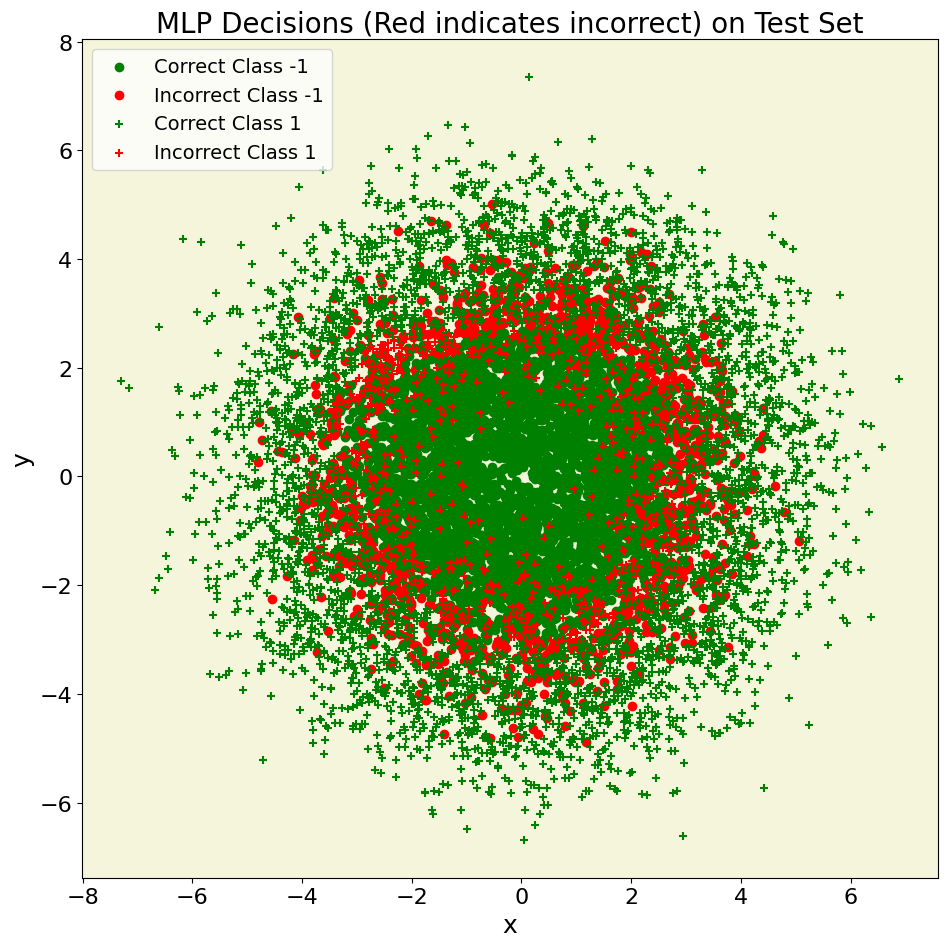

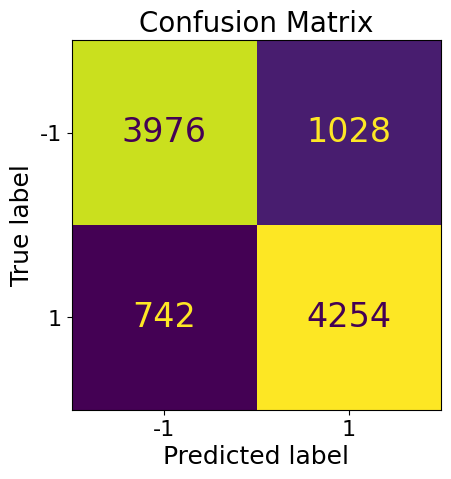

In [87]:
# Example Workflow
input_size = X_train.shape[1]
hidden_size = 64  # Best value based on cross-validation
lb = LabelBinarizer()
y_train_binary = torch.FloatTensor(lb.fit_transform(y_train)[:, 0])
y_test_binary = lb.transform(y_test)[:, 0]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

# Train the MLP model with restarts
best_mlp_model = train_with_restarts(TwoLayerMLP, input_size, hidden_size, X_train_tensor, y_train_binary)

# Evaluate and visualize the model's performance
evaluate_and_visualize(best_mlp_model, X_test_tensor, y_test_binary, lb)
